Siddhesh R. Kudale

# Making the spatial interpolation map for transit ridership

In [1]:
# Importing Shapefile with subway station data
import geopandas as gpd
fp = "Map1/geo_export_9a6789b4-3db4-46c2-980b-3342a7a7b6cf.shp"
data = gpd.read_file(fp)

# Importing Shapefile with NYC borough boundary data
bdry = "Boundary/geo_export_927131ad-d55f-48e0-8a33-8a784b0af41a.shp"
bdata = gpd.read_file(bdry)
bdata = bdata.drop([3])

data['lon'] = data.geometry.x
data['lat'] = data.geometry.y

%matplotlib inline

In [2]:
# Importing station-wise ridership data (open source; retrieved and cleaned from http://web.mta.info/nyct/facts/ridership/ridership_sub_annual.htm)
import pandas as pd
df = pd.read_excel('Map1/MTA Ridership.xlsx')

In [3]:
# Joining both datasets to continue
joined = pd.merge(df, data, left_on="Station", right_on="name")
joined.head()

Station   2013   2014   2015   2016   2017   2018  \
0  138th St - Grand Concourse   3222   3416   3480   3532   3486   3166   
1                     1st Ave  23467  24286  23789  23195  21823  20998   
2                    103rd St  13500  13318  13309  13246  12818  12569   
3                    103rd St  13500  13318  13309  13246  12818  12569   
4                    103rd St  13500  13318  13309  13246  12818  12569   

            line                        name  \
0            4-5  138th St - Grand Concourse   
1              L                     1st Ave   
2              1                    103rd St   
3          A-B-C                    103rd St   
4  4-6-6 Express                    103rd St   

                                               notes  objectid  \
0  4-all times, skips rush hours AM southbound, P...     141.0   
1                                        L-all times     146.0   
2                                        1-all times     159.0   
3  A-nights, B-weekdays and evenings, C-all times...     161.0   
4  4 nights, 6-all times, 6 Express-weekdays AM s...     458.0   

                                 url                    geometry        lon  \
0  http://web.mta.info/nyct/service/  POINT (-73.92985 40.81322) -73.929849   
1  http://web.mta.info/nyct/service/  POINT (-73.98168 40.73097) -73.981681   
2  http://web.mta.info/nyct/service/  POINT (-73.96838 40.79945) -73.968379   
3  http://web.mta.info/nyct/service/  POINT (-73.96137 40.79606) -73.961370   
4  http://web.mta.info/nyct/service/  POINT (-73.94748 40.79060) -73.947478   

         lat  
0  40.813224  
1  40.730975  
2  40.799446  
3  40.796061  
4  40.790600

In [4]:
# Importing essential libraries
import numpy as np
import pandas as pd
import glob
import adjustText as aT
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from shapely.geometry import Point, LineString, Polygon
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

In [5]:
# Interpolation 
lons=np.array(joined['lon']) 
lats=np.array(joined['lat']) 
zdata=np.array(joined[2017])
print(zdata)

for r in range(len(zdata)):
    if zdata[r]>100000:
        zdata[r] = 100000

print (zdata)

[  3486  21823  12818  12818  12818  14337  14337  14337   4674   4674
   4674  20101   1900   1727  11932  11384  11384  11384   2571   2571
   2571   3235   3235   3235  11553  11553  11553  15899  15899  15899
   7232   7232   7232  15263   1135   7584   7584   7584   7584  15692
  15692  15692  15692  29065  29065  29065  29065  28680  28680  28680
  28680  15023  15023   5770   5770  14049  43434  43434  43434  48565
  48565  48565 107141 107141 107141   9863   9863   9863   3540   3540
   3540  23932  23932  23932  14063  14063   6272   3804   3804  26674
  26674   4436   9466   9466  10223  10223  25589  25589   8671   8910
   8910   7089   7089   7466   5475  13217   6232   6196   6196   6196
   4318   4318   4318   3107   3107   3107   8680  11693  11693  10981
  10981   4990   6271   4719   8419  16675   2139   2139   5009   5009
   6524   1863  10209   1988   3439   4340  14763  14763  14763  14763
  14763  28479  28479  28479  28479  28479  24161  24161  24161  24161
  2416

In [6]:
# Setting bounds
xmin, ymin, xmax, ymax = bdata.total_bounds

In [7]:
xmin = xmin-0.01
xmax = xmax+0.01

ymin = ymin-0.01
ymax = ymax+0.01

grid_lon = np.linspace(xmin, xmax, 200)
grid_lat = np.linspace(ymin, ymax, 200)

In [8]:
# Spatial Kriging by linear method
OK = OrdinaryKriging(lons, lats, zdata, variogram_model='linear', verbose=True, enable_plotting=False,nlags=20)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
print (z1)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.0027199070900678635
Nugget: 288518685.5137301 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

[[15295.116175530966 15295.116175514446 15295.116175498124 ...
  15295.116173567676 15295.116173565855 15295.116173563656]
 [15295.116175541594 15295.116175525263 15295.116175508736 ...
  15295.116173568445 15295.116173566235 15295.116173564911]
 [15295.116175553554 15295.116175537009 15295.11617552035 ...
  15295.116173569602 15295.116173567883 15295.116173565671]
 ...
 [15295.11617755197 15295.116177542677 15295.116177532846 ...
  15295.116174723522 15295.116174716646 15295.116174709872]
 [15295.116177542684 15295.116177533346 15295.116177523996 ...
  15295.116174729945 15295.116174723318 15295.1161747164]
 [15295.116177534295 15295.116177524942 15295.116177514356 ...
  15295.116174736224 15295.116174729288 15295.1161747234

In [9]:
# Importing Shapefile with census tract boundaries 
fp1 = "Map2/Classmaps01.shp"
data1 = gpd.read_file(fp1)
data1 = data1.to_crs("EPSG:4326")

# Clipping tract boundaries by NYC borough boundary shapefile
clip = gpd.clip(data1, bdata)

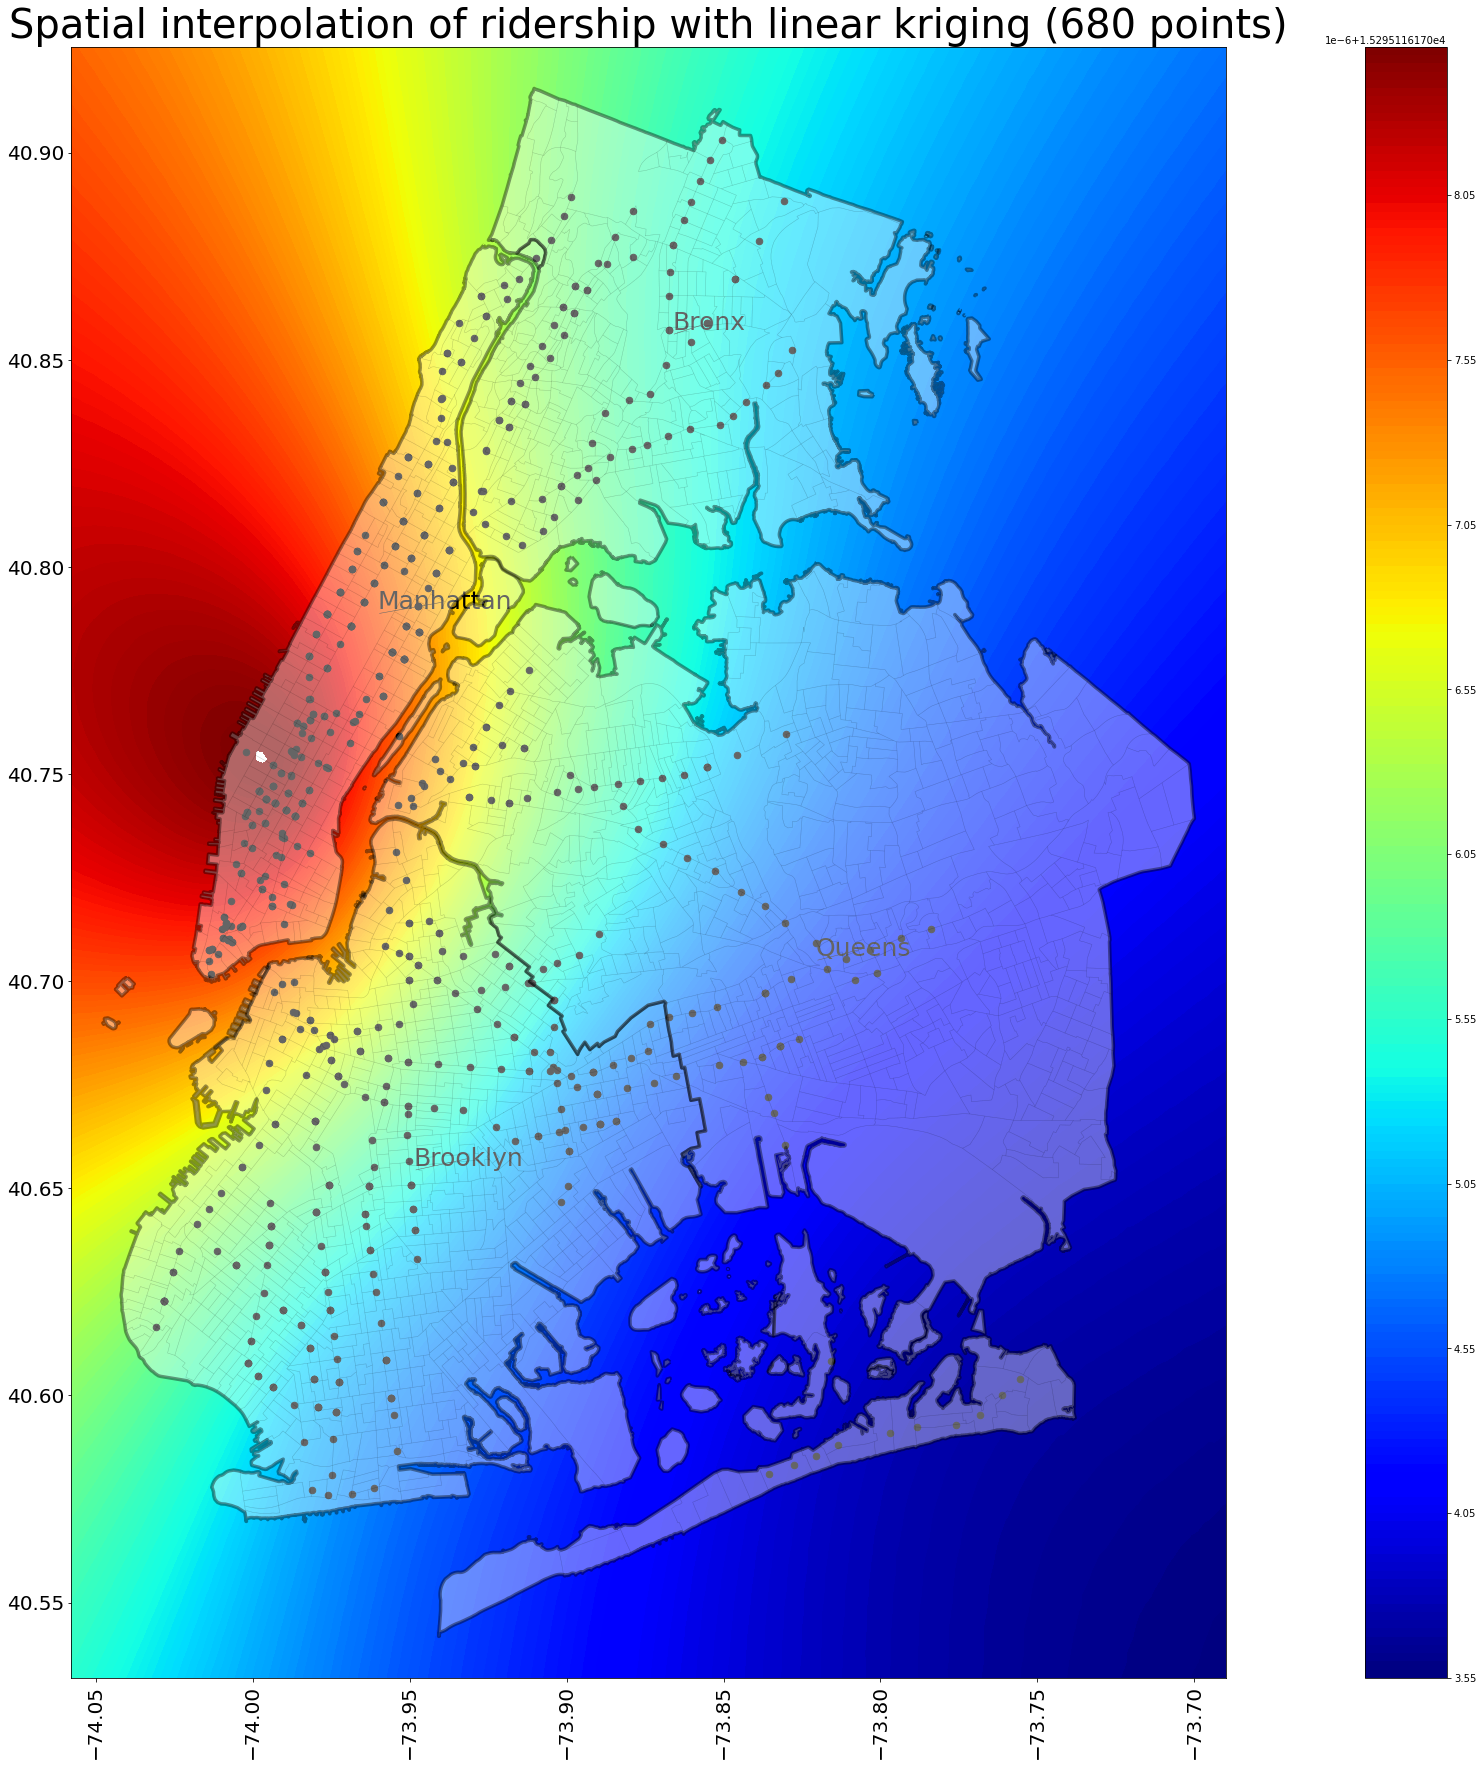

In [11]:
# Making the final interpolated plot
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(50,30))
boundarygeom = bdata.geometry
contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 1) 
plt.colorbar(contour)
bdata.plot(ax=ax, color='white', alpha = 0.4, linewidth=3.5, edgecolor='black', zorder = 40)
npts = len(lons)
plt.scatter(lons, lats, marker='.', c='black', s=npts/4)
plt.xticks(fontsize = 20, rotation=90)
plt.yticks(fontsize = 20)
plt.title('Spatial interpolation of ridership with linear kriging (%d points)' %npts, fontsize = 40)
clip.boundary.plot(ax=ax, alpha = 0.1, linewidth=0.5, edgecolor='black', zorder =40)

from shapely.geometry import Point
bdata["rep"] = bdata["geometry"].representative_point()
bdata_points = bdata.copy()

bdata_points.set_geometry("rep", inplace = True)
texts = []

for x, y, label in zip(bdata_points.geometry.x, bdata_points.geometry.y, bdata_points["boro_name"]):
    texts.append(plt.text(x, y, label, fontsize = 25))
aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.show()

----------------------------------------------------------------------------------------------------------------------

# Making the choropleth map of tractwise trip generation

In [12]:
# Importing Shapefile with census tract boundaries 
fp1 = "Map2/Classmaps01.shp"
data1 = gpd.read_file(fp1)

In [13]:
# Importing excel with census tract IDs and ridership data for various modes
df2 = pd.read_excel('Map2/Output1.xlsx')

# Retaining non-zero values only
df2 = df2[(df2['estimate'] > 0)]

# Grouping by tract to sum all modes for each tract
total = df2.groupby('GEOID').sum('estimate')
total = total.merge(df2, on = 'GEOID')
total = total[["GEOID", "NAME","estimate_x"]]
total = total[(total['estimate_x'] < 30000)]

In [14]:
total.head(27000)

GEOID                                        NAME  estimate_x
0      36005000200      Census Tract 2, Bronx County, New York        4609
1      36005000200      Census Tract 2, Bronx County, New York        4609
2      36005000200      Census Tract 2, Bronx County, New York        4609
3      36005000200      Census Tract 2, Bronx County, New York        4609
4      36005000200      Census Tract 2, Bronx County, New York        4609
...            ...                                         ...         ...
26215  36081162100  Census Tract 1621, Queens County, New York        9397
26216  36081162100  Census Tract 1621, Queens County, New York        9397
26217  36081162100  Census Tract 1621, Queens County, New York        9397
26218  36081162100  Census Tract 1621, Queens County, New York        9397
26219  36081162100  Census Tract 1621, Queens County, New York        9397

[26206 rows x 3 columns]

In [15]:
data1 = data1[~data1['GEOID'].isnull()]
data1['GEOID'] = data1['GEOID'].astype(str).str.replace('.', '')
data1 = data1[data1['GEOID'].str.isnumeric()]
data1[['GEOID']] = data1[['GEOID']].astype(int)

/tmp/ipykernel_439/3610585404.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data1['GEOID'] = data1['GEOID'].astype(str).str.replace('.', '')


In [16]:
data1.to_string('GEOID')
total.to_string('GEOID')
total = total.merge(data1, on='GEOID')

In [17]:
from geopandas import GeoDataFrame
total = GeoDataFrame(total)

In [18]:
total = total.to_crs("EPSG:4326")
clipped = gpd.clip(total, bdata)

In [19]:
clipped.head()

GEOID                                    NAME_x  estimate_x  \
7872  36047034000  Census Tract 340, Kings County, New York        1066   
7873  36047034000  Census Tract 340, Kings County, New York        1066   
7875  36047034000  Census Tract 340, Kings County, New York        1066   
7876  36047034000  Census Tract 340, Kings County, New York        1066   
7877  36047034000  Census Tract 340, Kings County, New York        1066   

     STATEFP COUNTYFP TRACTCE NAME_y          NAMELSAD  MTFCC FUNCSTAT  \
7872      36      047  034000    340  Census Tract 340  G5020        S   
7873      36      047  034000    340  Census Tract 340  G5020        S   
7875      36      047  034000    340  Census Tract 340  G5020        S   
7876      36      047  034000    340  Census Tract 340  G5020        S   
7877      36      047  034000    340  Census Tract 340  G5020        S   

         ALAND  AWATER     INTPTLAT      INTPTLON  \
7872  129694.0     0.0  +40.5723223  -073.9964764   
7873  129694.0     0.0  +40.5723223  -073.9964764   
7875  129694.0     0.0  +40.5723223  -073.9964764   
7876  129694.0     0.0  +40.5723223  -073.9964764   
7877  129694.0     0.0  +40.5723223  -073.9964764   

                                               geometry  
7872  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7873  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7875  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7876  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7877  POLYGON ((-74.00142 40.57310, -74.00031 40.572...

(array([40.5 , 40.55, 40.6 , 40.65, 40.7 , 40.75, 40.8 , 40.85, 40.9 ,
        40.95]),
 [Text(0, 40.5, '40.50'),
  Text(0, 40.55, '40.55'),
  Text(0, 40.6, '40.60'),
  Text(0, 40.65, '40.65'),
  Text(0, 40.7, '40.70'),
  Text(0, 40.75, '40.75'),
  Text(0, 40.8, '40.80'),
  Text(0, 40.85, '40.85'),
  Text(0, 40.9, '40.90'),
  Text(0, 40.95, '40.95')])

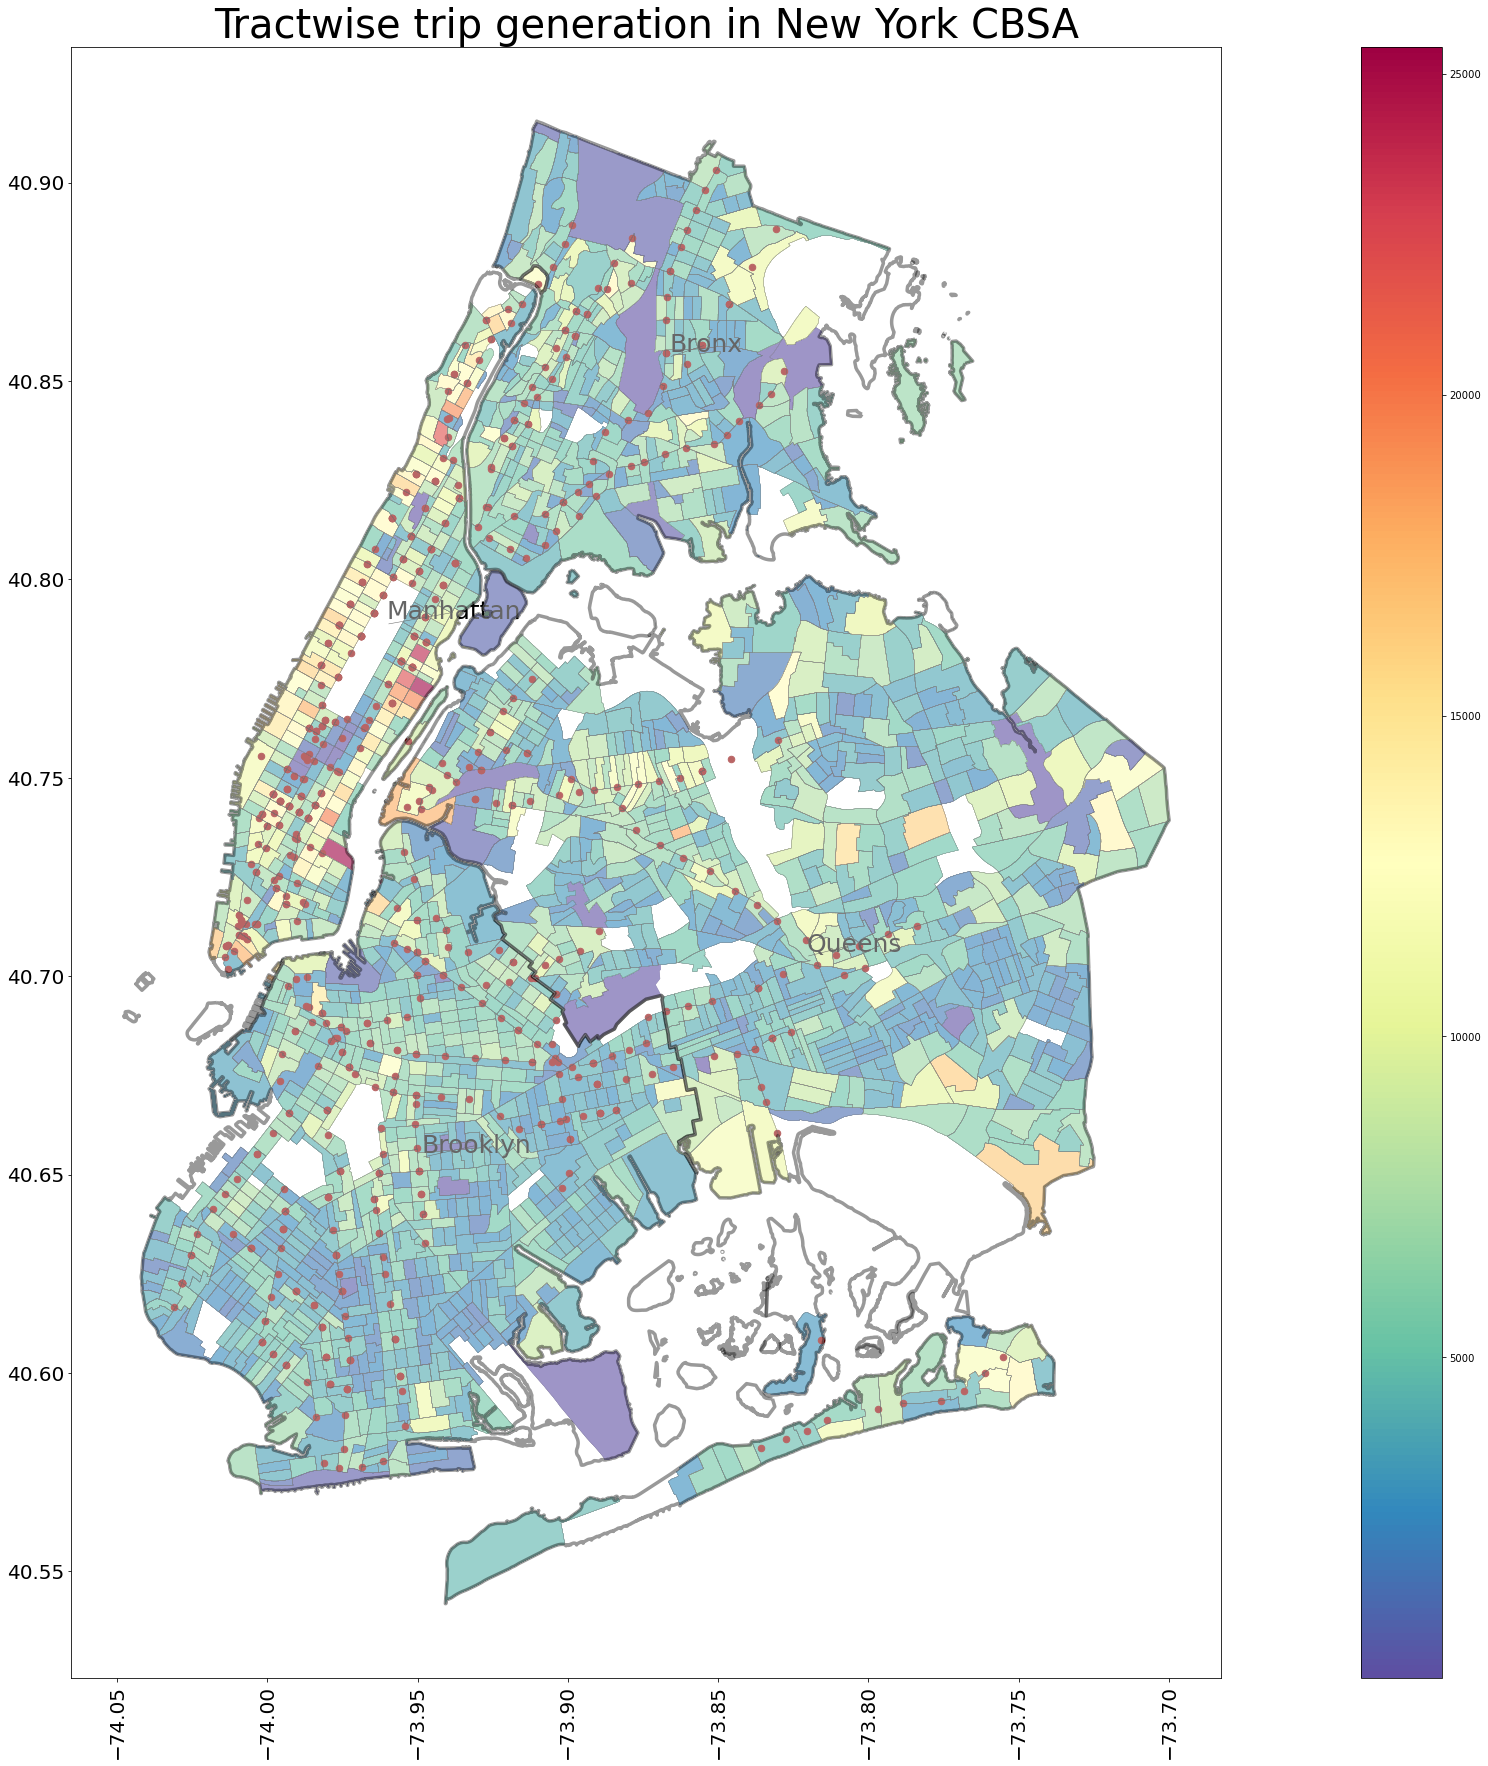

In [20]:
# Making the final plot for tractwise trip generation
fig, ax = plt.subplots(figsize=(50,30))
clipped.plot(column='estimate_x', ax=ax, cmap='Spectral_r', legend=True)
bdata.plot(ax=ax, color='white', alpha = 0.4, linewidth=3.5, edgecolor='black', zorder = 40)
clipped.boundary.plot(ax=ax, color = 'grey', alpha = 0.2, linewidth=0.2, edgecolor='black',zorder =40)
plt.scatter(lons, lats, marker='.', c='darkred', s=npts/4)

bdata["rep"] = bdata["geometry"].representative_point()
bdata_points = bdata.copy()

bdata_points.set_geometry("rep", inplace = True)
texts = []

for x, y, label in zip(bdata_points.geometry.x, bdata_points.geometry.y, bdata_points["boro_name"]):
    texts.append(plt.text(x, y, label, fontsize = 25))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.title('Tractwise trip generation in New York CBSA', fontsize = 40)

plt.xticks(fontsize = 20, rotation=90)
plt.yticks(fontsize = 20)

----------------------------------------------------------------------------------------------------------------------

# Generating centroids for census tracts

In [21]:
clipped2 = clipped
clipped2.head()

GEOID                                    NAME_x  estimate_x  \
7872  36047034000  Census Tract 340, Kings County, New York        1066   
7873  36047034000  Census Tract 340, Kings County, New York        1066   
7875  36047034000  Census Tract 340, Kings County, New York        1066   
7876  36047034000  Census Tract 340, Kings County, New York        1066   
7877  36047034000  Census Tract 340, Kings County, New York        1066   

     STATEFP COUNTYFP TRACTCE NAME_y          NAMELSAD  MTFCC FUNCSTAT  \
7872      36      047  034000    340  Census Tract 340  G5020        S   
7873      36      047  034000    340  Census Tract 340  G5020        S   
7875      36      047  034000    340  Census Tract 340  G5020        S   
7876      36      047  034000    340  Census Tract 340  G5020        S   
7877      36      047  034000    340  Census Tract 340  G5020        S   

         ALAND  AWATER     INTPTLAT      INTPTLON  \
7872  129694.0     0.0  +40.5723223  -073.9964764   
7873  129694.0     0.0  +40.5723223  -073.9964764   
7875  129694.0     0.0  +40.5723223  -073.9964764   
7876  129694.0     0.0  +40.5723223  -073.9964764   
7877  129694.0     0.0  +40.5723223  -073.9964764   

                                               geometry  
7872  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7873  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7875  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7876  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7877  POLYGON ((-74.00142 40.57310, -74.00031 40.572...

In [22]:
clipped3 = clipped2.drop(columns=['STATEFP', 'COUNTYFP','TRACTCE','NAME_y','NAMELSAD','MTFCC','FUNCSTAT','ALAND','AWATER'])
clipped3.head()

GEOID                                    NAME_x  estimate_x  \
7872  36047034000  Census Tract 340, Kings County, New York        1066   
7873  36047034000  Census Tract 340, Kings County, New York        1066   
7875  36047034000  Census Tract 340, Kings County, New York        1066   
7876  36047034000  Census Tract 340, Kings County, New York        1066   
7877  36047034000  Census Tract 340, Kings County, New York        1066   

         INTPTLAT      INTPTLON  \
7872  +40.5723223  -073.9964764   
7873  +40.5723223  -073.9964764   
7875  +40.5723223  -073.9964764   
7876  +40.5723223  -073.9964764   
7877  +40.5723223  -073.9964764   

                                               geometry  
7872  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7873  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7875  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7876  POLYGON ((-74.00142 40.57310, -74.00031 40.572...  
7877  POLYGON ((-74.00142 40.57310, -74.00031 40.572...

(array([40.5 , 40.55, 40.6 , 40.65, 40.7 , 40.75, 40.8 , 40.85, 40.9 ,
        40.95]),
 [Text(0, 40.5, '40.50'),
  Text(0, 40.55, '40.55'),
  Text(0, 40.6, '40.60'),
  Text(0, 40.65, '40.65'),
  Text(0, 40.7, '40.70'),
  Text(0, 40.75, '40.75'),
  Text(0, 40.8, '40.80'),
  Text(0, 40.85, '40.85'),
  Text(0, 40.9, '40.90'),
  Text(0, 40.95, '40.95')])

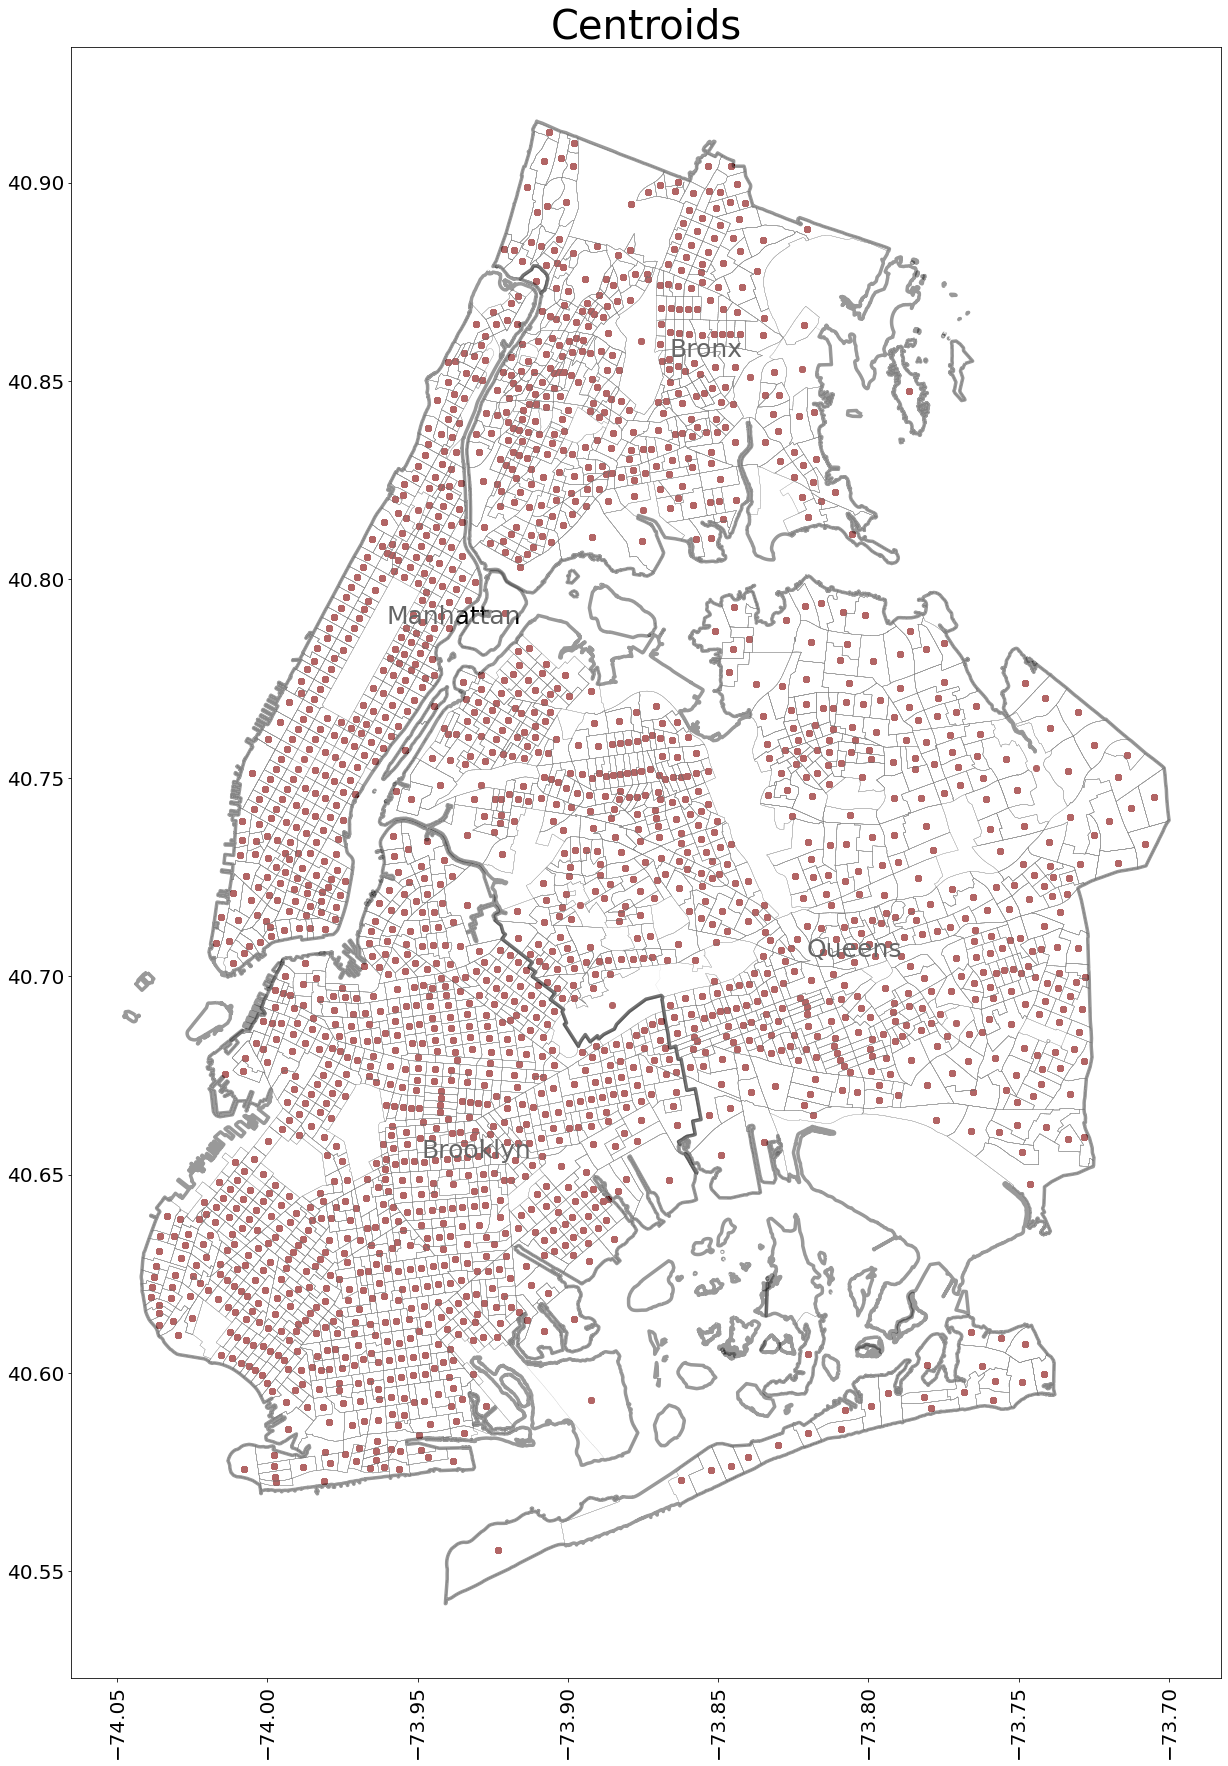

In [23]:
# Making a plot showing centroid locations for each census tract
fig, ax = plt.subplots(figsize=(50,30))
bdata.plot(ax=ax, color='white', alpha = 0.4, linewidth=3.5, edgecolor='black', zorder = 40)
clipped.boundary.plot(ax=ax, color = 'grey', alpha = 0.2, linewidth=0.2, edgecolor='black',zorder =40)

bdata["rep"] = bdata["geometry"].representative_point()
bdata_points = bdata.copy()

bdata_points.set_geometry("rep", inplace = True)
texts = []

for x, y, label in zip(bdata_points.geometry.x, bdata_points.geometry.y, bdata_points["boro_name"]):
    texts.append(plt.text(x, y, label, fontsize = 25))
    
clipped["rp"] = clipped.representative_point()
clipped_point = clipped.copy()
clipped_point.set_geometry("rp", inplace = True)

clipped.rp.plot(ax=ax, color = 'maroon')

plt.title('Centroids', fontsize = 40)

plt.xticks(fontsize = 20, rotation=90)
plt.yticks(fontsize = 20)

----------------------------------------------------------------------------------------------------------------------

# Extracting required interpolated data

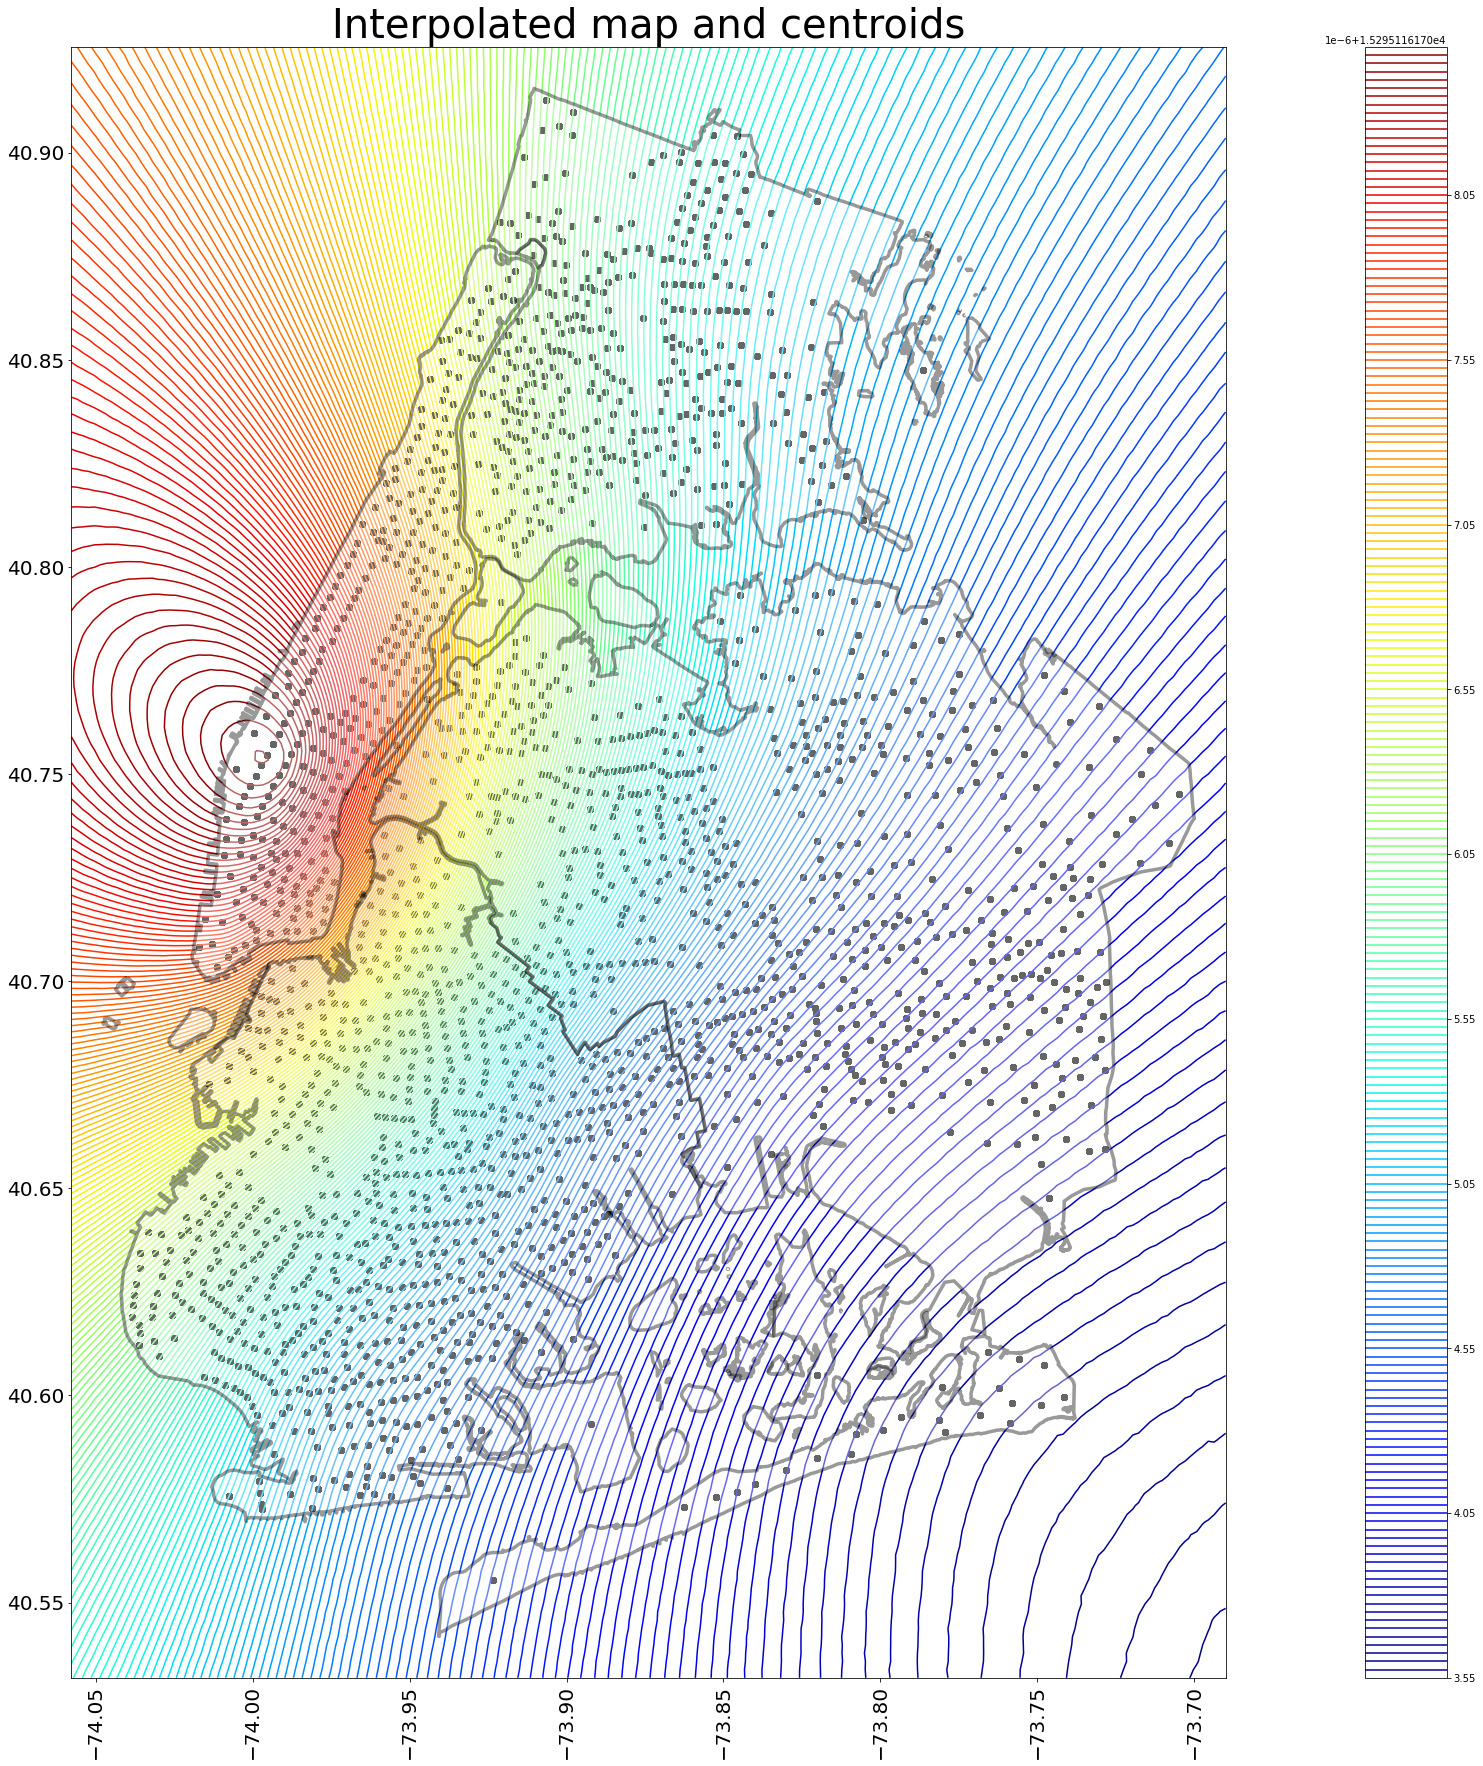

In [41]:
# Making a plot showing interpolated data and extraction points
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(50,30))
contour = plt.contour(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 1) 
plt.colorbar(contour)
boundarygeom = bdata.geometry
bdata.plot(ax=ax, color='white', alpha = 0.4, linewidth=3.5, edgecolor='black', zorder = 40)
clipped.rp.plot(ax=ax, color = 'black')
npts = len(lons)
plt.title('Interpolated map and centroids', fontsize = 40)
plt.xticks(fontsize = 20, rotation=90)
plt.yticks(fontsize = 20)
plt.show()

----------------------------------------------------------------------------------------------------------------------

# Comparing the results

In [25]:
clipped3.to_excel(r'Data.xlsx', index = False, header=True)

In [26]:
dataf = pd.read_excel('Dataf.xlsx')
dataf.head()

GEOID                                    NAME_x  estimate_y  \
0  36047034000  Census Tract 340, Kings County, New York        1066   
1  36047034000  Census Tract 340, Kings County, New York        1066   
2  36047034000  Census Tract 340, Kings County, New York        1066   
3  36047034000  Census Tract 340, Kings County, New York        1066   
4  36047034000  Census Tract 340, Kings County, New York        1066   

   estimate_x   INTPTLAT   INTPTLON  \
0      1172.6  40.572322 -73.996476   
1      1279.2  40.572322 -73.996476   
2      1385.8  40.572322 -73.996476   
3      1492.4  40.572322 -73.996476   
4      1599.0  40.572322 -73.996476   

                                            geometry  \
0  POLYGON ((-74.00142099999999 40.573102, -74.00...   
1  POLYGON ((-74.00142099999999 40.573102, -74.00...   
2  POLYGON ((-74.00142099999999 40.573102, -74.00...   
3  POLYGON ((-74.00142099999999 40.573102, -74.00...   
4  POLYGON ((-74.00142099999999 40.573102, -74.00...   

                                      rp                      point  
0  POINT (-73.99698409676216 40.5725345)  (-73.9964764, 40.5723223)  
1  POINT (-73.99698409676216 40.5725345)  (-73.9964764, 40.5723223)  
2  POINT (-73.99698409676216 40.5725345)  (-73.9964764, 40.5723223)  
3  POINT (-73.99698409676216 40.5725345)  (-73.9964764, 40.5723223)  
4  POINT (-73.99698409676216 40.5725345)  (-73.9964764, 40.5723223)

<function matplotlib.pyplot.show(close=None, block=None)>

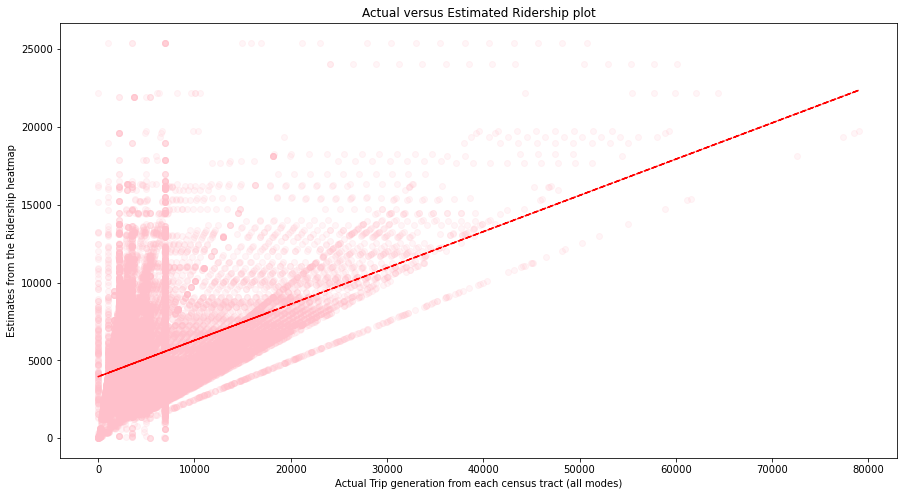

In [39]:
# Making a scatter plot to show the difference in estimation
plt.figure(figsize=(15,8))
plt.scatter(dataf['estimate_x'],dataf['estimate_y'],alpha=0.15, color = 'pink')
plt.title("Actual versus Estimated Ridership plot")
z = np.polyfit(dataf['estimate_x'],dataf['estimate_y'], 1)
p = np.poly1d(z)
plt.plot(dataf['estimate_x'],p(dataf['estimate_x']),"r--")
plt.xlabel("Actual Trip generation from each census tract (all modes)")
plt.ylabel("Estimates from the Ridership heatmap")
plt.show 

----------------------------------------------------------------------------------------------------------------------